 # 沪深300指数纯因子组合构建

 > WIFA量化组，2019年春。

In [1]:
import os                                    # for getting working directory.
path = os.getcwd()                           # current working directory.
import pandas as pd                          # for wrapping csv file.
import numpy as np                           # for numerical manipulation.
import seaborn as sns                        # for plotting.
sns.set(style = "darkgrid")                  # set seaborn style.
import matplotlib.pyplot as plt              # specify "plt".
plt.rcParams['font.sans-serif'] = ['SimHei'] # For displaying chinese.
plt.rcParams['axes.unicode_minus'] = False   # For displaying minus sign.
import math                                  # math calculation.
from statsmodels import regression           # for OLS.
import statsmodels.api as sm                 # for OLS result.


In [0]:
# Import Wind Module for getting data.
import WindPy as w
from WindPy import *
w.start()


In [2]:
def get_factor_list():
    '''
    Return:
        factor list. (list)
    '''
    # The factor list stores the factor string I need.
    return [
    "pe_ttm",
    "pb_lf",
    "pcf_ncf_ttm",
    "ps_ttm",
    "yoyprofit",
    "yoy_or",
    "yoyroe",
    "roe_ttm2",
    "roa_ttm2",
    "debttoassets",
    "assetsturn",
    "invturn",
    "pct_chg_1m",
    "pct_chg_3m",
    "pct_chg_6m",
    "stdevry_3m",
    "stdevry_6m",
    "tech_turnoverrate20",
    "tech_turnoverrate60",
    "val_lnmv"
]
# 其中"pct_chg_1m",
#     "pct_chg_3m",
#     "pct_chg_6m",
#     "stdevry_3m",
#     "stdevry_6m",不好从wsd中取,"pct_chg_1m", "pct_chg_3m","pct_chg_6m"是根据pct_chg计算的，波动率提取要填开始区间和截止区间（区间为近几个月）


In [3]:
Large_Factors_list = ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY','INDUSTRY','SIZE']


In [0]:
def get_hs300_stocks_list():
    '''
    Return:
        hs300 stocks list. (pd.DataFrame)
    '''
    file_path = path + "\\H3 Data\\Raw Data\\hs300.csv"
    if os.path.isfile(file_path):
        hs300_data = pd.read_csv(
            open(
                file_path, 
                'r', 
                encoding = "utf-8"
            ), 
            index_col = [0]
        )
    else:
        # Getting the stock list of HS300.
        hs300_stocks_list = list(w.wset(
            "sectorconstituent", 
            "date=2019-02-20;windcode=000300.SH", # base on recent date.
            usedf = True
        )[1]['wind_code'])
        hs300_data = pd.DataFrame(
            data = hs300_stocks_list, 
            columns = ["HS300"]
        )
        hs300_data.to_csv(file_path)
    return list(hs300_data["HS300"])


In [0]:
get_hs300_stocks_list()


In [0]:
def data_fetching_and_storing(
    start = "2005-01-01", 
    end = "2019-02-20"
):
    '''
    Parameters:
        start: start date (YYYY-MM-DD). (str)
        end: end date (YYYY-MM-DD). (str)
    Return:
        save raw data to "\\H3 Data\\Raw Data\\" as csv.
    '''
    # Import data from wind and store it as csv.
    for factor in get_factor_list():
        factor_data = w.wsd(
            get_hs300_stocks_list(), 
            factor, 
            start, 
            end, 
            "Period=M", 
            usedf = True # use pandas dataframe.
        )[1]             # the result is a tuple with the [1] part is what we need.
        # Make a new directory (H3 Data) for storing data.
        file_path = path + "\\H3 Data\\Raw Data\\" + factor + ".csv" # name the data file by it's factor string.
        factor_data.to_csv(file_path) # store data.


In [0]:
data_fetching_and_storing()


In [0]:
def sw_industry_data_fetching_and_storing():
    '''
    Return:
        save SHENWAN industry data to "\\H3 Data\\Raw Data\\" as csv.
    '''
    industry_sw = w.wsd(
        get_hs300_stocks_list(), 
        "industry_sw", 
        "2019-02-20", 
        "2019-02-20", # set the start and end date as the same.
        "industryType=1;Period=M",
        usedf = True 
    )[1]
    file_path = path + "\\H3 Data\\Raw Data\\industry_sw.csv"
    industry_sw.to_csv(file_path)


In [0]:
# sw_industry_data_fetching_and_storing()


In [0]:
##########################################################################################################################33


 # Step 2：Factor Data Processing.

 ## 2.1 Filtering & 2.2 Filling

In [4]:
def get_data(factor_name): # get data from disk.
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        forward-filled factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    # 让这个函数可以直接取这几个动量因子
    if factor_name in ["pct_chg_1m","pct_chg_3m","pct_chg_6m"]:
        data_raw = data = pd.read_csv(open(
            path + "\\H3 Data\\Raw Data\\" + 'pct_chg' + ".csv",
            'r', # read-only mode for data protection.
            encoding = "utf-8" ), index_col = [0])
        if factor_name == 'pct_chg_1m':
            data = data_raw
        elif factor_name == 'pct_chg_3m':
            data_raw.fillna(0, inplace=True)
            data = pd.DataFrame(index=data_raw.index,columns=data_raw.columns)
            for i in range(3,len(data_raw)):
                data.iloc[i,:] = (data_raw.iloc[i-1,:]/100+1)*(data_raw.iloc[i-2,:]/100+1)*(data_raw.iloc[i-3,:]/100+1)-1
        elif factor_name == 'pct_chg_6m':
            data_raw.fillna(0, inplace=True)
            data = pd.DataFrame(index=data_raw.index, columns=data_raw.columns)
            for i in range(6, len(data_raw)):
                data.iloc[i, :] = (data_raw.iloc[i - 1, :]/100 + 1) * (data_raw.iloc[i - 2, :]/100 + 1) * (
                    data_raw.iloc[i - 3, :]/100 + 1)* (
                    data_raw.iloc[i - 4, :]/100 + 1)* (
                    data_raw.iloc[i - 5, :]/100 + 1)* (
                    data_raw.iloc[i - 6, :]/100 + 1) - 1
        data = data.replace(0,np.nan)
    else:
        data = pd.read_csv(
            open(
                # Extract raw data.
                path + "\\H3 Data\\Raw Data\\" + factor_name + ".csv",'r', # read-only mode for data protection.
                encoding = "utf-8"
            ),
            index_col = [0]
        )
    # Forward-fill nan to make quarter report fill the month.
    data.fillna(method = 'ffill', inplace = True)
    # Make all date format in the same way.
    data.index = pd.to_datetime(data.index).strftime('%Y%m%d')
    data = data.loc['20090131':'20190131']
    return data


In [5]:
def get_values(data):
    '''
    Parameter:
        data: input data. (pd.DataFrame)
    Return:
        a list of all values in data except nan. (list)
    '''
    # Collect all non-nan value into data_list.
    value_list = []
    for i in range(len(data.columns)): 
        # is there a way to avoid loop?
        value_list += data.iloc[:, i].dropna().tolist()
    return value_list


In [6]:
def overview():
    '''
    Return:
        save a 3*3 histogram distribution plot of original data.
    '''
    # Get an overview of 9 of the factors histogram distribution plot.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = get_data(get_factor_list()[i])
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("不同因子在A股的历史数据分布")
    plt.savefig(path + "\\H3 Plots\\overview.png")


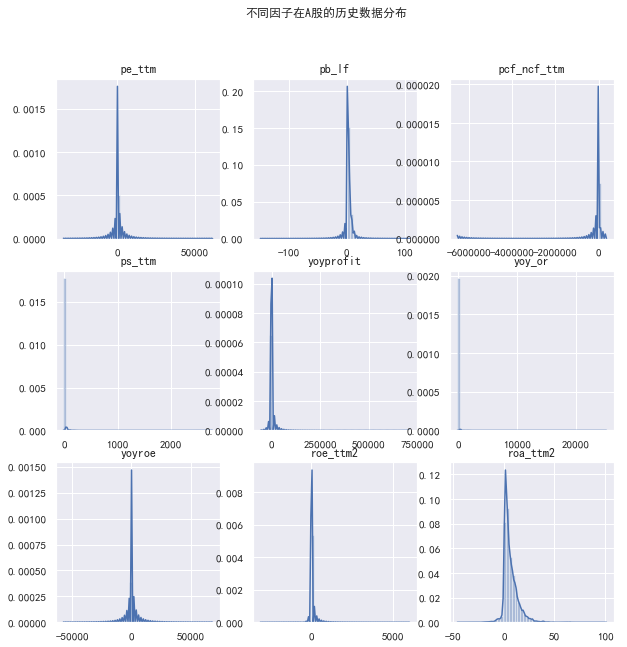

In [7]:
overview()


 ## 2.1 Filter Extreme Value.

In [16]:
class Filter(object):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    '''
    def __init__(self, factor_name):
        data = get_data(factor_name)
        self.data = data
        self.values = get_values(
            data = data
        )
    
    def original(self):
        '''
        Return:
            original unfiltered data. (pd.DataFrame)
        '''
        return self.data
    
    def MAD(self, n = 60):
        '''
        Parameter:
            n: how many times new median. (int)
        Return:
            filtered data. (pd.DataFrame)
        '''
        median = np.percentile(self.values, 50)
        new_median = np.percentile(
            get_values(abs(self.data - median)), 50
        )
        min_range = median - n * new_median
        max_range = median + n * new_median
        return self.data.clip(min_range, max_range, axis = 1)
    
    def three_sigma(self, n = 3):
        '''
        Parameter:
            n: how many sigmas. (int)
        Return:
            filtered data. (pd.DataFrame)
        '''
        min_range = np.mean(self.values) - n * np.std(self.values)
        max_range = np.mean(self.values) + n * np.std(self.values)
        return self.data.clip(min_range, max_range, axis = 1)
    
    def percentile_filter(self, min = 0.5, max = 99.5):
        '''
        Parameters:
            min: minimum percentage. (float)
            max: maximum percentage. (float)
        Return:
            filtered data. (pd.DataFrame)
        '''
        min_range = np.percentile(self.values, min)
        max_range = np.percentile(self.values, max)
        return np.clip(self.data, min_range, max_range)


In [17]:
def overview_MAD():
    '''
    Return:
        save a 3*3 histogram distribution plot of 
        MAD-filtered data.
    '''
    # Get an overview of MAD method filtering.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = Filter(get_factor_list()[i]).MAD()
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("绝对值差中位数法(MAD法)去极值后")
    plt.savefig(path + "\\H3 Plots\\MAD.png")


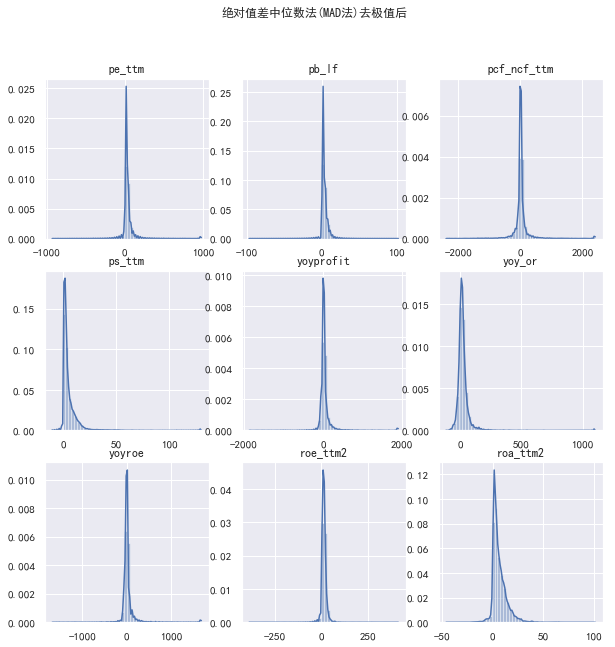

In [18]:
overview_MAD()

In [19]:
def overview_three_sigma():
    '''
    Return:
        save a 3*3 histogram distribution plot of 
        3sigma-filtered data.
    '''
    # Get an overview of 3 sigma method filtering.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = Filter(get_factor_list()[i]).three_sigma()
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("3σ法去极值后")
    plt.savefig(path + "\\H3 Plots\\3σ.png")


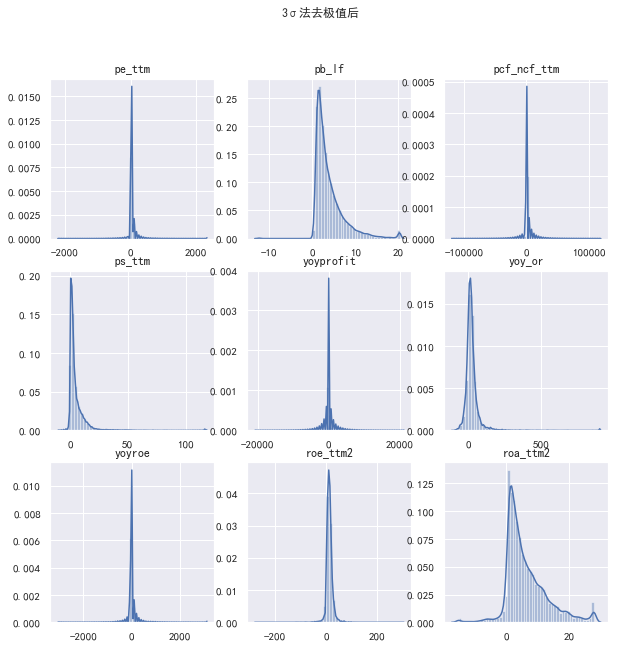

In [20]:
overview_three_sigma()

In [21]:
def overview_percentile():
    '''
    Return:
        save a 3*3 histogram distribution plot of 
        percentile-filtered data.
    '''
    # Get an overview of percentile method filtering.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = Filter(get_factor_list()[i]).percentile_filter()
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("百分位法去极值后")
    plt.savefig(path + "\\H3 Plots\\percentile.png")


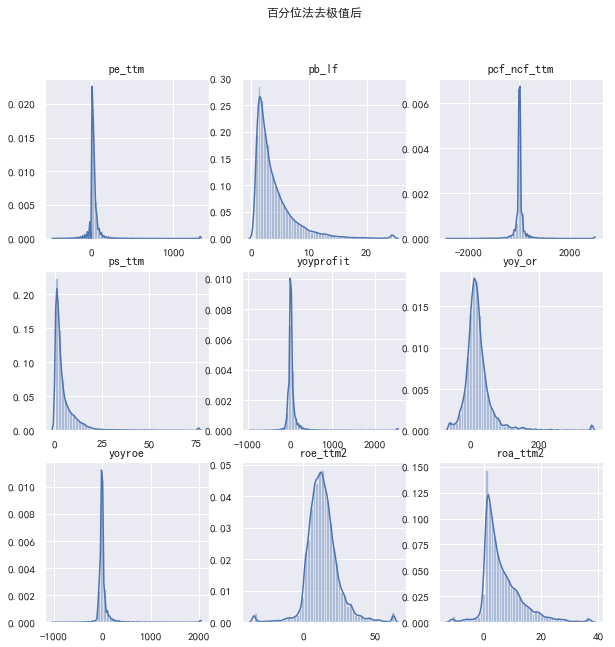

In [22]:

overview_percentile()


In [23]:
def huge_deviation_original_data():
    '''
    Return:
        save a histogram distribution plot of 
        original data with huge deviation.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").original()
    ), label = "Percentile")
    plt.legend()
    plt.title("每股现金流：原始数据")
    plt.savefig(path + "\\H3 Plots\\original pcf_ncf_ttm.png")


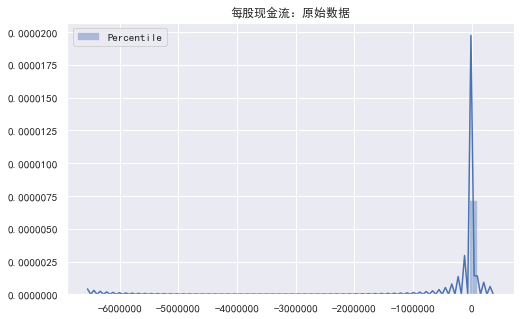

In [24]:
huge_deviation_original_data()


In [25]:
def huge_deviation_filtered_data():
    '''
    Return:
        save a histogram distribution plot of 
        percentile-filtered data with huge deviation.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").percentile_filter()
    ), label = "Percentile")
    plt.legend()
    plt.title("每股现金流：百分位去极值")
    plt.savefig(path + "\\H3 Plots\\percentile filter pcf_ncf_ttm.png")


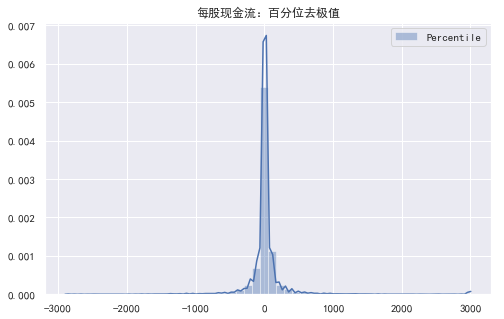

In [26]:
huge_deviation_filtered_data()


In [27]:
def huge_deviation_filter_method_comparison():
    '''
    Return:
        save a histogram distribution plot of 
        a hugely deviated data for different filter method comparison.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").original()
    ), label = "Original")
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").MAD()
    ), label = "MAD")
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").three_sigma()
    ), label = "3σ")
    sns.distplot(get_values(
        data = Filter("pcf_ncf_ttm").percentile_filter()
    ), label = "Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以每股现金流为例）")
    plt.savefig(path + "\\H3 Plots\\Comparison(pcf_ncf_ttm).png")


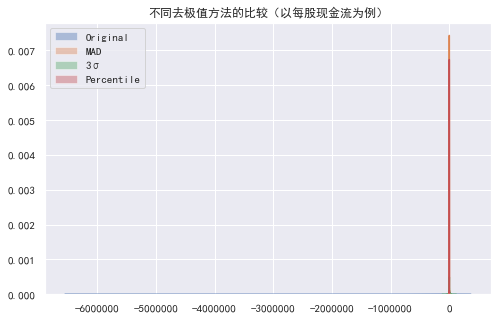

In [28]:
huge_deviation_filter_method_comparison()


In [29]:
def filter_method_comparison():
    '''
    Return:
        save a histogram distribution plot of
        a normal data for different filter method comparison.
    '''
    plt.figure(figsize = (8, 5))
    sns.distplot(get_values(
        data = Filter("assetsturn").original()
    ), label = "Original")
    sns.distplot(get_values(
        data = Filter("assetsturn").MAD()
    ), label = "MAD")
    sns.distplot(get_values(
        data = Filter("assetsturn").three_sigma()
    ), label = "3σ")
    sns.distplot(get_values(
        data = Filter("assetsturn").percentile_filter()
    ), label = "Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以资产周转率为例）")
    plt.savefig(path + "\\H3 Plots\\Comparison(assetsturn).png")


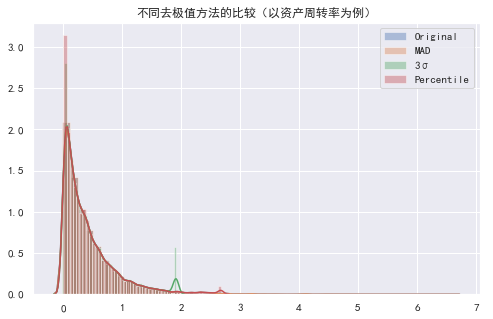

In [30]:
filter_method_comparison()


 ## 2.3 standardize

In [31]:
# Use z-score method to standardize.
def standardize(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        standardized and Filtered (MAD) data. (pd.DataFrame)
    '''
    data = Filter(factor_name).MAD()
    data = data.fillna(0)
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std


In [32]:
def process_and_store_data():
    '''
    Return:
        save processed data in "\\H3 Data\\Processed Data\\".
        ("processed" means filtered & standardized.)
    '''
    for factor in get_factor_list():
        processed_data = standardize(factor)
        file_path = path + "\\H3 Data\\Processed Data\\" + factor + ".csv"
        processed_data.to_csv(file_path)


In [33]:
process_and_store_data()


In [34]:
def get_processed_data(factor_name): # get data from disk.
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        processed factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            path + "\\H3 Data\\Processed Data\\" + factor_name + ".csv", 
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ), 
        index_col = [0]
    )
    return data


In [0]:
def overview_processed_data():
    # Get an overview of processed data.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data = get_processed_data(get_factor_list()[i])
        ))
        plt.title(get_factor_list()[i])
    plt.suptitle("经过处理后的A股因子数据密度分布图一览")
    plt.savefig(path + "\\H3 Plots\\Processed Data.png")


In [0]:
overview_processed_data()


In [0]:
def get_industry_data():
    '''
    Return:
        SHENWAN industry data. (pd.DataFrame)      
    '''
    return get_processed_data("industry_sw")


In [0]:
def get_industry_list():
    '''
    Return:
        industry list in HS300 stocks list.
    '''
    return list(get_industry_data().iloc[:, 0].unique())


In [0]:
def industry_comparison(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        average factor value of each industries. (pd.DataFrame)
            index: industry. (str)
            columns: factor name. (str)
    '''
    # All industry in HS300.
    sw_industry_list = get_industry_list()
    # Use certain factor data for comparison example between industry.
    compare_data = get_data(factor_name)
    compare_industry = pd.DataFrame(
        index = sw_industry_list, 
        columns = [factor_name]
    )
    for industry in sw_industry_list:
        industry_stock_code_list = list(get_data("industry_sw")[
            get_data("industry_sw").iloc[:, 0] == industry
        ].index)
        # Some industry is not in HS300. 
        try:
            industry_data = compare_data[industry_stock_code_list]
            compare_industry.loc[
                industry, factor_name
            ] = np.mean(np.mean(industry_data))
        except:
            continue
    compare_industry.dropna(inplace = True)
    return compare_industry


In [0]:
def plot_industry_comparison():
    '''
    Return:
        save a 2*2 plot of average factor of each industries, 
        which are all siginificantly different. 
    '''
    # Choose 4 factors that's significantly different among industries. 
    significant_comparison_industry_list = [
        "pcf_ncf_ttm", 
        "yoyprofit", 
        "yoyroe", 
        "invturn"
    ]
    plt.figure(figsize = (21, 18)) # it's a big plot.
    for i in range(len(significant_comparison_industry_list)):
        plot_data = industry_comparison(
            significant_comparison_industry_list[i]
        )
        plt.subplot(int("22" + str(i+1)))
        sns.barplot(
            x = plot_data.index, 
            y = significant_comparison_industry_list[i], 
            data = plot_data
        )
        plt.xticks(rotation = 60) # rotate to avoid overlap text.
        plt.title(
            significant_comparison_industry_list[i], 
            fontsize = 21
        )
    plt.suptitle(
        "沪深300中不同行业部分因子平均值比较", 
        fontsize = 36
    )
    plt.savefig(path + "\\H3 Plots\\Industry Comparison.png")


In [0]:
plot_industry_comparison()


In [0]:
print(round(
    industry_comparison("pcf_ncf_ttm").loc["有色金属", "pcf_ncf_ttm"] /  
    industry_comparison("pcf_ncf_ttm").loc["家用电器", "pcf_ncf_ttm"] , 
    0
))


In [0]:
def get_industry_exposure(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        industry exposure data. (pd.DataFrame)
    '''
    file_path = path + "\\H3 Data\\Neutralized Data\\industry exposure " + factor_name + ".csv"
    if os.path.isfile(file_path):
        industry_exposure = pd.read_csv(
            open(
                file_path, 
                'r', 
                encoding = "utf-8"
            ), 
            index_col = [0]
        )
    else:
        # Don't know why but different factor data has different hs300 stocks list, 
        # so specify which factor is essential.
        hs300_stock_list = list(get_data(factor_name).columns)
        industry_exposure = pd.DataFrame(
            index = get_industry_list(), 
            columns = hs300_stock_list
        )
        for stock in hs300_stock_list:
            try:
                industry_exposure.loc[
                    get_industry_data().loc[
                        stock, 
                        "INDUSTRY_SW"
                    ], 
                    stock
                ] = 1
            except:
                continue
        industry_exposure.fillna(0, inplace = True)
        industry_exposure.to_csv(file_path)
    return industry_exposure


In [0]:
def neutralize(
    factor_name, 
    market_capital = True, 
    industry = True
):
    '''
    Parameters:
        factor_name: name of factors in Wind. (str)
        market_capital: whether market-capital-neutralize or not. (bool)
        industry: whether industry-neutralize or not. (bool)
    Return:
        neutralized data. (pd.DataFrame)
    '''
    y = get_processed_data(factor_name).T.fillna(0) # don't know why but there's still nan.
    industry_dummy = get_industry_exposure(factor_name)
    if market_capital:
        ln_market_capital = get_data("val_lnmv")
        if industry:
            x = pd.concat(
                [
                    ln_market_capital, 
                    industry_dummy
                ], 
                axis = 1
            )
        else:
            x = ln_market_capital
    elif industry:
        x = industry_dummy.T
    result = sm.OLS(
        y.astype(float), 
        x.astype(float)
    ).fit()
    return result.resid.T


In [0]:
def plot_industry_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize = (8, 5))
    sns.kdeplot(get_values(
        data = get_processed_data(factor_name)
    ), label = "未经中性化")
    sns.kdeplot(get_values(
        data = neutralize(
            factor_name, 
            market_capital = False, 
            industry = True
        )
    ), label = "行业中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行中性化处理前后比较")


In [0]:
def overview_neutralization(factor_list):
    '''
    Parameter:
        factor_list: list of factor names. (list)
    Return:
        save a 2*2 plot of neutralization comparison.
    '''
    factor_list = factor_list
    plt.figure(figsize = (10, 10))
    for i in range(len(factor_list)):
        plt.subplot(int("22" + str(i+1)))
        sns.kdeplot(get_values(
            data = get_processed_data(factor_list[i])
        ), label = "未经中性化")
        sns.kdeplot(get_values(
            data = neutralize(
                factor_list[i], 
                market_capital = False, 
                industry = True
            )
        ), label = "行业中性化")
        plt.legend()
        plt.title("对" + factor_list[i] + "进行中性化处理前后比较")
    plt.suptitle("行业中性化的典型结果")
    plt.savefig(path + "\\H3 Plots\\overview neutralization.png")


In [0]:
overview_neutralization([
    "pb_lf",
    "debttoassets", 
    "assetsturn", 
    "invturn"
])


In [0]:
def neutralize_and_store_data():
    '''
    Return:
        save industry neutralized data in 
        "\\H3 Data\\Neutralized Data\\".
    '''
    for factor in get_factor_list():
        file_path = path + "\\H3 Data\\Neutralized Data\\" + factor + ".csv"
        neutralized_data = neutralize(
            factor, 
            market_capital = False, 
            industry = True
        )
        neutralized_data.to_csv(file_path)


In [0]:
neutralize_and_store_data()


In [0]:
def get_neutralized_data(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        neutralized factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            path + "\\H3 Data\\Neutralized Data\\" + factor_name + ".csv", 
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ), 
        index_col = [0]
    )
    return data


In [0]:
def overview_after_data_processing():
    # Get an overview of data after processing.
    plt.figure(figsize = (10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        factor_name = get_factor_list()[i]
        sns.distplot(get_values(
            data = get_neutralized_data(factor_name)
        ))
        plt.title(factor_name)
    plt.suptitle("经过数据处理后的不同因子在A股的历史数据分布")
    plt.savefig(path + "\\H3 Plots\\overview after data processing.png")


In [0]:
overview_after_data_processing()

########################################################################################################################

 # STEP 3

In [0]:
# Turn dataframe into panel data. 
def get_group_data(factor_list):
    '''
    Parameter:
        factor_list: list of factor names. (str list)
    Return:
        panel data of all factors data. (pd.Panel)
    '''
    datadict = {}
    for i in factor_list:
        df = get_neutralized_data(i) # this should be the processed data
        datadict[i] = df
    panel = pd.Panel(datadict)
    return panel


In [0]:
class Large_factor_merge(object):
    '''
    Parameters:
        Large_factor: large factor data. (pd.Panel)
    '''
    def __init__(self, Large_factor):
        if Large_factor == 'VALUE':
            list = ["pe_ttm","pb_lf","pcf_ncf_ttm","ps_ttm"]
        elif Large_factor =='GROWTH':
            list = ["yoyprofit","yoy_or","yoyroe"]
        elif Large_factor =='PROFIT':
            list = ["roe_ttm2","roa_ttm2"]
        elif Large_factor == 'QUALITY':
            list = ["debttoassets","assetsturn","invturn"]
        elif Large_factor =='MOMENTUM':
            list = ['pct_chg_1m','pct_chg_3m','pct_chg_6m']
        elif Large_factor =='VOLATILITY':
            list = ["stdevry_3m","stdevry_6m"]
        elif Large_factor == 'LIQUIDITY':
            list = ["tech_turnoverrate60","tech_turnoverrate20"]
        data = get_group_data(list)
        self.data = data
        self.Large_factor = Large_factor
    # Define the following function for you can read clearly and can acquire the data of every step.

    def Caculate_IC(self):
        '''
        Return:
            IC of Large Factor.         
        '''
        stock_return = get_neutralized_data('pct_chg')# This will be modified
        datadict = {}
        for i in self.data.items:
            df = self.data[i]
            IC = pd.DataFrame(columns=['IC_monthly'],index = df.index[0:len(df)-1])
            IC_group = []
            for j in range(len(df)-1):
                cor = df.iloc[j].corr(stock_return.iloc[j+1])
                IC_group.append(cor)
            IC['IC_monthly'] = IC_group
            datadict[i] = IC
        IC_Large = pd.Panel(datadict)
        return IC_Large

    def Caculate_IR(self):
        '''
        Return:
            IR of Large Factor. 
        '''
        IC_Large = self.Caculate_IC()
        weight_df = pd.DataFrame(columns=['weights'],index=self.data.items)
        weight = []
        for i in IC_Large.items:
            df = IC_Large[i]
            IR = df.iloc[-24:,0].mean()/df.iloc[-24:,0].std()
            weight.append(IR)
        weight = [x/sum(weight) for x in weight] #adjust the sum of weight to 1.0
        weight_df['weights'] = weight
        return weight_df

    def Factors_merge(self):
        '''
        Return:
            the merged large factor data.
        '''
        weight = self.Caculate_IR()
        # I don't find more attribute for panel data for sum.
        Factors_sum = pd.DataFrame(0,columns=self.data.minor_axis,index=self.data.major_axis)
        for i in self.data.items:
            df = self.data[i]
            new_df = df*weight.loc[i,'weights']
            Factors_sum = Factors_sum +new_df
        return Factors_sum


In [0]:
def Merge_and_store_factors():
    Factor_dict = {}
    for i in ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY']:
        Factor_data = Large_factor_merge(i).Factors_merge()
        Factor_dict[i] = Factor_data
        file_path = path + "\\H3 Data\\large factor data\\" + i + ".csv"
        Factor_data.to_csv(file_path)
    Large_factor = pd.Panel(Factor_dict)
    return Large_factor
Large_factor = Merge_and_store_factors()
# when you want to use one factor,you can edit'Large_factor[the name of the factor]'



In [0]:
def get_Large_Factors(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        neutralized factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(
        open(
            path + "\\H3 Data\\large factor data\\" + factor_name + ".csv",
            'r', # read-only mode for data protection.
            encoding = "utf-8"
        ),
        index_col = [0]
    )
    return data


In [0]:
def overview_Large_factors():
    # Get an overview of data after processing.
    plt.figure(figsize = (10, 10))
    for i in range(7):
        plt.subplot(int("33" + str(i+1)))
        factor_name = Large_Factors_list[i]
        sns.distplot(get_values(
            data = get_Large_Factors(factor_name)
        ))
        plt.title(factor_name)
    plt.suptitle("大类因子在A股的历史数据分布")
    plt.savefig(path + "\\H3 Plots\\Large Factors.png")

overview_Large_factors()

##############################################################################################################################

 # STEP 5

In [0]:
# 假设了之前很多回归的计算结果
from scipy.optimize import minimize
Factor_income =pd.DataFrame(-1+2*np.random.random((121,9)),columns=['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY','INDUSTRY','SIZE'],
                            index = get_neutralized_data('ps_ttm').index)
Stock_predict = pd.DataFrame(-0.1+np.random.random((300,1))/3,columns=['yeild_forecast'],index = get_neutralized_data('ps_ttm').columns)
Factor_predict = pd.DataFrame(-0.1+np.random.random((300,9))/3,columns=['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY','INDUSTRY','SIZE'],index = get_neutralized_data('ps_ttm').columns)
#每只股票的在不同时间点的残差，可以等于实际的股票收益率-预测的股票收益率
Stock_Residual = pd.DataFrame(-0.1+np.random.random((121,300))/5,columns = get_neutralized_data('ps_ttm').columns,index = get_neutralized_data('ps_ttm').index)


class Portfolio_Optimization(object):
    def __init__(self, Target_factors ,time_window):
        self.Target_factors = Target_factors
        self.time_window = time_window

    def Factor_covariance(self):
        factors = Factor_income.iloc[-self.time_window:]
        Cov = np.cov(factors.values.T)
        return Cov

    # 预测残差风险这一部分很复杂，用到半衰期权重和贝叶斯收缩，和波动性调整，其实不约束风险时，不用计算此项，先把框架搭起来，
    # 后面计算组合的夏普比率要用到组合方差，就要用到残差风险，后续研究我们再仔细研究这一部分具体怎么算
    def Trait_risk_forecast(self):
        Res = pd.DataFrame(-0.1+np.random.random((300,300))/5)
        return Res

    def optimization(self):
        Cov = self.Factor_covariance()
        Res = self.Trait_risk_forecast()
        yeild_T_1 = Stock_predict

        #非线性规划
        x0 = np.random.rand(300)
        x0 /= sum(x0)
        Non_target_factors = list(set(Large_Factors_list) ^ set(self.Target_factors))
        n = len(Non_target_factors)
        m = list(range(n))
        b = [0]*9
        b[0:n-1] = m
        # 此处我尝试了各种方法，用i遍历非目标纯因子然后生成条件，但是生成的条件在优化模型中没有被成功约束，最后只能全部写出来9个因子条件，
        # 对于目标纯因子，序数取的0，即条件是重复的非目标因子约束，这里的条件数据类型是tuple，tuple不能被增加，我试过先用list添加然后转为tuple,
        # 仍然没有被成功识别，如果有更简便的方法，欢迎提出
        # 最小化的函数
        func = lambda x: -(yeild_T_1 * np.mat(x).T).sum()[0]
        cons4 = ({'type': 'eq', 'fun': lambda x: x.sum() - 1},
                 {'type': 'ineq','fun': lambda x:(0.03-abs((Factor_predict[[Non_target_factors[b[0]]]]*np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[1]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[2]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[3]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[4]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[5]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[6]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[7]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[8]]]] * np.mat(x).T).sum()[0]))},
                 )
        # 如果要添加波动性约束，条件要改为以下，我写的是限制波动小于3%
        '''cons4 = ({'type': 'eq', 'fun': lambda x: x.sum() - 1},
                 {'type': 'ineq','fun': lambda x: (0.03 -((np.mat(Factor_predict).T*np.mat(x).T).T*Cov*(np.mat(Factor_predict).T*np.mat(x).T))[0,0]
                                    +(np.mat(x)*np.mat(Res)*np.mat(x).T))[0,0]},
                {'type': 'ineq', 'fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[0]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[1]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[2]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[3]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[4]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[5]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[6]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[7]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[8]]]] * np.mat(x).T).sum()[0]))},
                 )'''
        c = (0,1)
        bnds = tuple([c]*300)#边界条件为0-1
        res = minimize(func, x0, method='SLSQP', constraints=cons4,bounds = bnds)
        Stock_weight = pd.DataFrame(res.x,columns=['Portfolio Weight'],index = Stock_predict.index)
        return  Stock_weight, -res.fun

# 目标纯因子为'VALUE','GROWTH','PROFIT'，使用历史时间段为过去32个月，仅对非目标纯因子偏离做约束条件，最大化收益，返回权重和组合收益
#[Stock_weight,Portfolio_Return]= Portfolio_Optimization(['VALUE','GROWTH','PROFIT'],32).optimization()
